# Build Time-networks based on year of first PMID for an edge

We will build networks representing the state of knowledge at different timepoints.  This will be done by filtering edges by date, using the PMID associated with the earliest timepoint for each given edge.

In [1]:
import os
import pickle
import pandas as pd
from tqdm import tqdm, tqdm_pandas

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')

import sys
sys.path.append('../../hetnet-ml/src')
import graph_tools as gt

## Build a final ID to year map

Each map came from a different source, so make sure they are consistent in type

In [2]:
nlm = pickle.load(open('../data/pmid_to_year_NLM.pkl', 'rb'))
pmc = pickle.load(open('../data/pmid_to_year_PMC.pkl', 'rb'))
eur = pickle.load(open('../data/pmid_to_year_Eur.pkl', 'rb'))
ebi = pickle.load(open('../data/pmid_to_year_EBI.pkl', 'rb'))

There may be type differences between these maps, lets check.  
Ideally we want, `key=str: value=int`.

In [3]:
key = list(nlm.keys())[0]
value = nlm[key]
print('{!r}: {!r}'.format(key, value))

'395177': '1979'


`{str: str}`

In [4]:
key = list(pmc.keys())[0]
value = pmc[key]
print('{!r}: {!r}'.format(key, value))

'25136495': 2014


`{str: int}`

In [5]:
key = list(eur.keys())[0]
value = eur[key]
print('{!r}: {!r}'.format(key, value))

'25136495': '2014'


`{str: str}`

In [6]:
key = list(ebi.keys())[0]
value = ebi[key]
print('{!r}: {!r}'.format(key, value))

'26389298': '2018-05-11'


`{str: str}` with year formatted as `YYYY-MM-DD`

#### Reformatting the maps

`{str: int}` with only the year is the most useful for our purposes, so format all of these maps to this schema

In [7]:
for k, v in tqdm(nlm.items()):
    nlm[k] = int(v)

100%|██████████| 27836723/27836723 [00:41<00:00, 673871.18it/s]


In [8]:
for k, v in tqdm(eur.items()):
    eur[k] = int(v)

100%|██████████| 3561213/3561213 [00:03<00:00, 897683.89it/s]


In [9]:
for k, v in tqdm(ebi.items()):
    ebi[k] = int(v.split('-')[0])

100%|██████████| 7937/7937 [00:00<00:00, 203649.59it/s]


In [10]:
# order of importance right to left. (pmc values will replace all others)
id_to_year = {**eur, **nlm, **ebi, **pmc}
id_to_year = {str(k): v for k, v in id_to_year.items()}

## Bring in the nodes and edges files

In [11]:
tqdm.pandas()

In [12]:
nodes = gt.remove_colons(pd.read_csv('../data/nodes_VER31_R_cons_6_metanode.csv'))
nodes.head(2)

,id,name,label,id_source
0,C0229664,peripheral blood,Anatomy,UMLS
1,C0545822,"Esophagus, stomach and duodenum",Anatomy,UMLS


In [13]:
edges = gt.remove_colons(pd.read_csv('../data/edges_VER31_R_cons_6_metanode.csv'))
edges['pmids'] = edges['pmids'].progress_apply(eval)
edges.head(2)

100%|██████████| 7207765/7207765 [02:18<00:00, 52207.70it/s]


,start_id,end_id,type,pmids,n_pmids
0,D011740,C0814995,AFFECTS_CDafA,{3722832},1
1,D011458,D005704,AFFECTS_CDafA,"{2645856, 11728432}",2


## Edge type breakdown by PMID count in final network

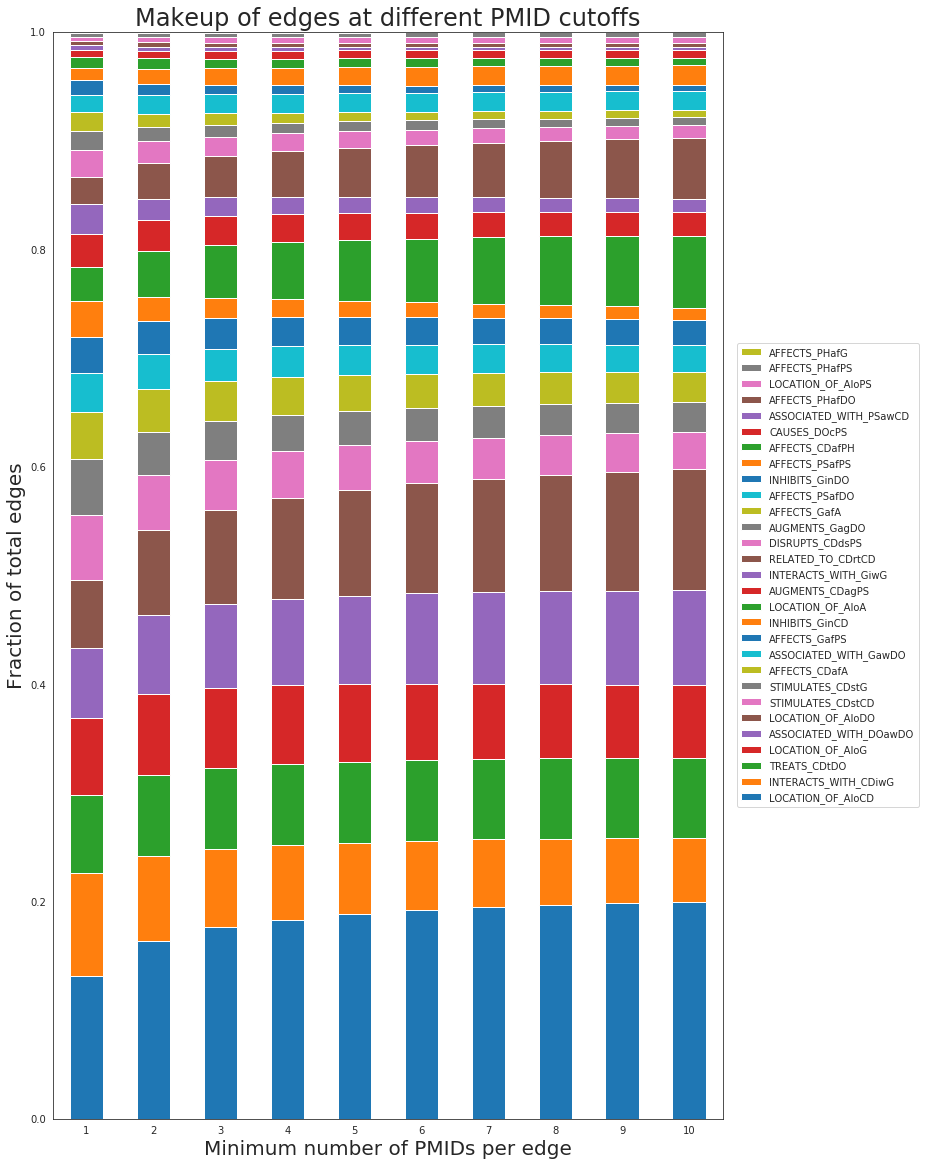

In [14]:
frame = pd.DataFrame()
for i in range(10):

    to_plot = edges.query('n_pmids > @i')['type'].value_counts()
    to_plot = to_plot / to_plot.sum()
    frame[i+1] = to_plot
    
    
fig = frame.T.plot.bar(stacked=True, figsize=(12, 20))
handels, labels = fig.axes.get_legend_handles_labels()
plt.legend(handels[::-1], labels[::-1], loc=7, bbox_to_anchor=(1.3, 0.5))
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.title('Makeup of edges at different PMID cutoffs', size=24)
plt.xlabel('Minimum number of PMIDs per edge', size=20)
plt.ylabel('Fraction of total edges', size = 20);

## Now apply the ID to Year Map

In [15]:
# turn pmids into a list so order is preserved
edges['pmids'] = edges['pmids'].apply(list)
edges.head(2)

,start_id,end_id,type,pmids,n_pmids
0,D011740,C0814995,AFFECTS_CDafA,[3722832],1
1,D011458,D005704,AFFECTS_CDafA,"[2645856, 11728432]",2


In [16]:
# Ideally just want minimum year for a given edge, so supplying 9999 for not found pmids will
# allow min() to be used on the resulting list.
edges['pub_years'] = edges['pmids'].progress_apply(lambda pmids: [id_to_year.get(str(p), 9999) for p in pmids])
edges.head(2)

100%|██████████| 7207765/7207765 [00:57<00:00, 125852.98it/s]


,start_id,end_id,type,pmids,n_pmids,pub_years
0,D011740,C0814995,AFFECTS_CDafA,[3722832],1,[1986]
1,D011458,D005704,AFFECTS_CDafA,"[2645856, 11728432]",2,"[1989, 2001]"


In [17]:
edges['first_pub'] = edges['pub_years'].progress_apply(min)
edges.head(2)

100%|██████████| 7207765/7207765 [00:19<00:00, 376201.44it/s]


,start_id,end_id,type,pmids,n_pmids,pub_years,first_pub
0,D011740,C0814995,AFFECTS_CDafA,[3722832],1,[1986],1986
1,D011458,D005704,AFFECTS_CDafA,"[2645856, 11728432]",2,"[1989, 2001]",1989


## Now the get the dates from the gold standard.

In [18]:
indications = pd.read_csv('../data/indications_nodemerge.csv')
indications.head(2)

,id,struct_id,concept_id,relationship_name,disease_name,umls_cui,snomed_full_name,cui_semantic_type,snomed_conceptid,compound_name,compound_semmed_id,disease_semmed_id,approval_date,approval_year
0,173432,965,40249340,indication,Malignant tumor of breast,C0006142,Malignant tumor of breast,T191,254837009.0,drostanolone propionate,C007561,DOID:1612,NaN,NaN
1,173433,318,21000716,indication,Gout,C0018099,Gout,T047,90560007.0,benzbromarone,D001553,DOID:13189,NaN,NaN


In [19]:
len(indications)

8279

Some NA values in the date, won't be useul for this analysis so just drop them

In [20]:
indications.dropna(subset=['approval_year'], inplace=True)
indications['approval_year'] = indications['approval_year'].astype(int)

In [21]:
len(indications)

7100

## Filter nodes and edges by year to build the network

In [22]:
base_dir = '../data/time_networks-6_metanode'

In [23]:
def get_year_category(diff):
    if diff > 20:
        return '20+ After'
    elif diff >= 15 and diff < 20:
        return '15-20 After'
    elif diff >= 10 and diff < 15:
        return '10-15 After'
    elif diff >= 5 and diff < 10:
        return '5-10 After'
    elif diff >= 0 and diff < 5:
        return '0-5 After'
    elif diff >= -5 and diff < 0:
        return '0-5 Before'
    elif diff >= -10 and diff < -5:
        return '5-10 Before'
    elif diff >= -15 and diff < -10:
        return '10-15 Before'
    elif diff >= -20 and diff < -15:
        return '15-20 Before'
    elif diff < -20:
        return '20+ Before'

In [24]:
def plot_figure(indications, year, out_dir):
    
    order = ['20+ Before',
         '15-20 Before',
         '10-15 Before',
         '5-10 Before',
         '0-5 Before',
         '0-5 After',
         '5-10 After',
         '10-15 After',
         '15-20 After',
         '20+ After']
    
    
    plt.clf()
    plt.figure(figsize=(6, 4.5))

    f = sns.countplot(x='year_cat', data=indications, order=order)
    
    plt.ylabel('Count')
    plt.xlabel('Years from approval and {}'.format(year))
    plt.xticks(rotation=45)

    xlim = f.axes.get_xlim()
    x_mid = (xlim[1] + xlim[0]) / 2

    tick_diff = f.get_yticks()[1] - f.get_yticks()[0]
    y_height = f.get_yticks()[-2] - tick_diff/5 

    plt.text(3*x_mid/2, y_height, 'Total indications:\n          {}'.format(len(indications)))


    plt.title('Distribution of approval years for {}'.format(year))
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, 'ind-distribution.png'));

  0%|          | 0/15 [00:00<?, ?it/s]

Year: 1950
IDs: 8,707
Nodes: 8,707
Edges: 31,764
Indications: 701




  7%|▋         | 1/15 [00:03<00:53,  3.85s/it]

Year: 1955
IDs: 12,710
Nodes: 12,710
Edges: 61,383
Indications: 1,121




 13%|█▎        | 2/15 [00:07<00:49,  3.79s/it]

Year: 1960
IDs: 16,232
Nodes: 16,232
Edges: 91,420
Indications: 1,755




 20%|██        | 3/15 [00:11<00:47,  4.00s/it]

Year: 1965
IDs: 20,503
Nodes: 20,503
Edges: 131,693
Indications: 2,187




 27%|██▋       | 4/15 [00:18<00:51,  4.69s/it]

Year: 1970
IDs: 25,945
Nodes: 25,945
Edges: 192,721
Indications: 2,550




 33%|███▎      | 5/15 [00:25<00:54,  5.45s/it]

Year: 1975
IDs: 34,217
Nodes: 34,217
Edges: 308,954
Indications: 3,076




 40%|████      | 6/15 [00:35<01:00,  6.67s/it]

Year: 1980
IDs: 46,973
Nodes: 46,973
Edges: 571,906
Indications: 3,633




 47%|████▋     | 7/15 [00:48<01:10,  8.77s/it]

Year: 1985
IDs: 60,156
Nodes: 60,156
Edges: 948,894
Indications: 4,166




 53%|█████▎    | 8/15 [01:06<01:20, 11.57s/it]

Year: 1990
IDs: 74,136
Nodes: 74,136
Edges: 1,482,037
Indications: 4,573




 60%|██████    | 9/15 [01:31<01:32, 15.48s/it]

Year: 1995
IDs: 89,186
Nodes: 89,186
Edges: 2,189,382
Indications: 4,879




 67%|██████▋   | 10/15 [02:03<01:42, 20.50s/it]

Year: 2000
IDs: 103,525
Nodes: 103,525
Edges: 3,051,231
Indications: 5,099




 73%|███████▎  | 11/15 [02:43<01:45, 26.30s/it]

Year: 2005
IDs: 116,478
Nodes: 116,478
Edges: 4,098,063
Indications: 5,238




 80%|████████  | 12/15 [03:32<01:38, 32.99s/it]

Year: 2010
IDs: 124,395
Nodes: 124,395
Edges: 5,241,061
Indications: 5,311




 87%|████████▋ | 13/15 [04:29<01:20, 40.41s/it]

Year: 2015
IDs: 130,944
Nodes: 130,944
Edges: 6,540,941
Indications: 5,330




 93%|█████████▎| 14/15 [05:34<00:47, 47.80s/it]

Year: 2020
IDs: 133,314
Nodes: 133,314
Edges: 7,064,671
Indications: 5,336




100%|██████████| 15/15 [06:44<00:00, 54.42s/it]


<Figure size 432x288 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

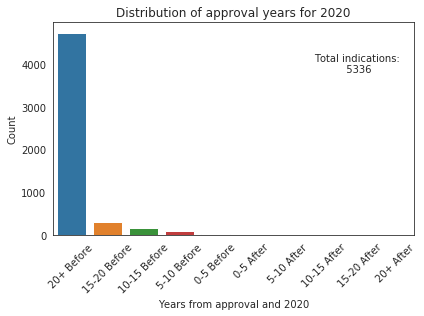

In [25]:
for year in tqdm(range(1950, 2025, 5)):

    # Define the save directory
    out_dir = os.path.join(base_dir, str(year))

    # Make sure the save directory exists, if not, make it
    try:
        os.stat(out_dir)
    except:
        os.makedirs(out_dir)       
    
    # Filter the edges by year
    e_filt = edges.query('first_pub <= @year')

    # Keep only nodes that have edges joining them
    node_ids = set(e_filt['start_id']).union(set(e_filt['end_id']))
    n_filt = nodes.query('id in @node_ids')

    # Keep only indications that have both the compound and disease still existing in the network
    ind_filt = indications.query('compound_semmed_id in @node_ids and disease_semmed_id in @node_ids').reset_index(drop=True)

    # Determine the difference between the current year and approval
    ind_filt['year_diff'] = ind_filt['approval_year'] - year
    ind_filt['year_cat'] = ind_filt['year_diff'].apply(get_year_category)

    print("Year: {}\nIDs: {:,}\nNodes: {:,}\nEdges: {:,}\nIndications: {:,}\n\n".format(
        year, len(node_ids), len(n_filt), len(e_filt), len(ind_filt)))
    
    # Save the network, indications, and summary figure
    (gt.add_colons(n_filt, id_name='cui')
       .to_csv(os.path.join(out_dir, 'nodes.csv'), index=False))
    (gt.add_colons(e_filt, col_types={'n_pmids':'INT', 'first_pub':'INT'})
       .to_csv(os.path.join(out_dir, 'edges.csv'), index=False))
    ind_filt.to_csv(os.path.join(out_dir, 'indications.csv'), index=False)
    plot_figure(ind_filt, year, out_dir);